In [1]:
import os
from os.path import join
from pathlib import Path
import cv2
from natsort import natsorted
import matplotlib.pyplot as plt
from ultralytics import YOLO
import xml.etree.ElementTree as ET
from copy import deepcopy
from random import choice
from tqdm.notebook import tqdm_notebook as ntqdm

import torch
plt.rcParams['figure.figsize'] = [15, 10]

# Testing XML 

In [ ]:
# annotations = ET.Element('annotations')
# version = ET.SubElement(annotations, 'version')
# meta = ET.parse('notebooks/meta.xml')
# meta_root = copy.deepcopy(meta.getroot())

# # meta_root = meta.getroot()
# annotations.insert(1, meta_root)

# img = ET.SubElement(annotations, 'image', name='wt234r5234', width='1280', height='720')
# box = ET.SubElement(img, 'box', label='spike', source='manual', occluded='0', xtl="586.70", ytl="255.24", xbr="675.20", ybr="489.50", z_order="0")
# box = ET.SubElement(img, 'box', label='block', source='manual', occluded='0', xtl="586.70", ytl="255.24", xbr="675.20", ybr="489.50", z_order="0")

# tree = ET.ElementTree(annotations)
# ET.indent(tree, space="\t", level=0)
# tree.write('lets-check.xml')



# Fetching Action Detector

In [2]:
cd ..

/home/masoud/Desktop/projects/volleyball_analytics


/home/masoud/anaconda3/envs/p/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from src.ml.yolo.vb_action.action_detection import ActionDetector
from src.utilities.utils import BoundingBox


In [4]:
cfg = {
        'weight': 'weights/vb_actions_6_class/model1/weights/best.pt',
        "labels": {0: 'ball', 1: 'block', 2: 'receive', 3: 'set', 4: 'spike', 5: 'serve'}
    }

In [5]:
detector = ActionDetector(cfg)

In [6]:
image_dir = '/media/masoud/HDD-8TB/datasets/VOLLEYBALL/pics/spike'
images = natsorted(list(Path(image_dir).glob('*.png')))
meta_file = open('notebooks/meta.xml')
print("images are ", len(images))

images are  532


In [8]:
# action_detector = ActionDetector(cfg=cfg)
torch.cuda.empty_cache()


0: 576x1024 271 balls, 17 receives, 9 sets, 1 spike, 2 serves, 4.3ms
Speed: 3.7ms preprocess, 4.3ms inference, 148.2ms postprocess per image at shape (1, 3, 576, 1024)


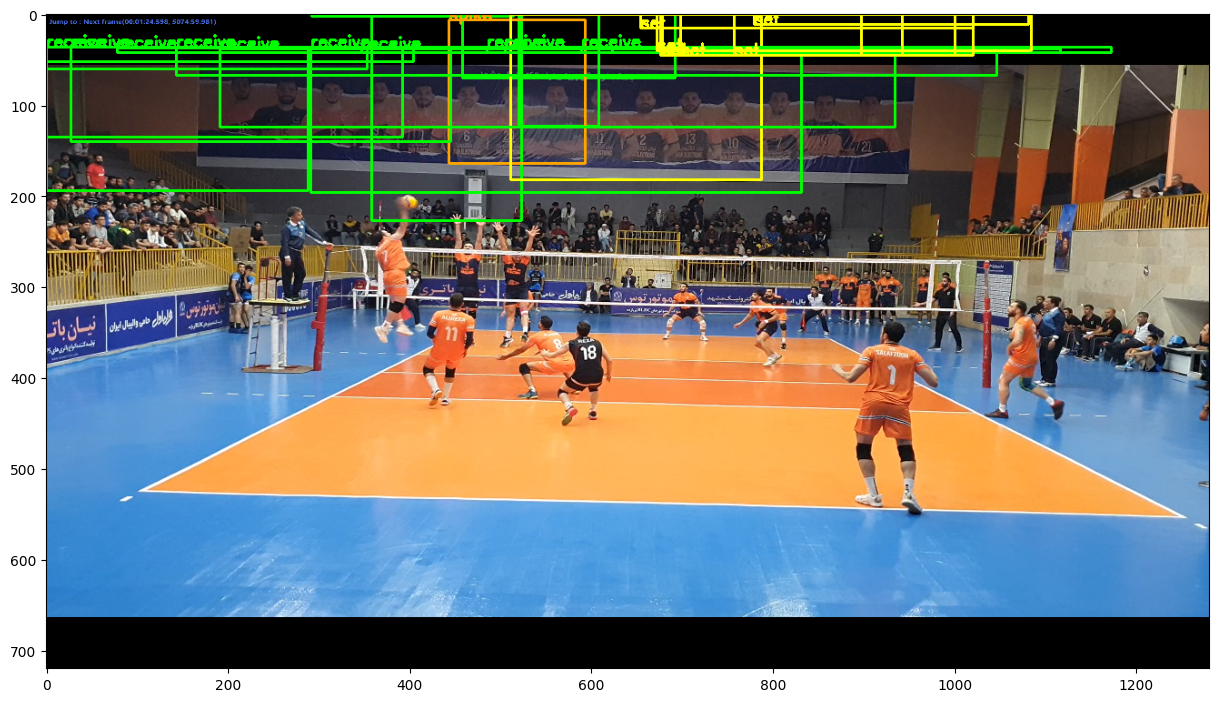

In [9]:
path = choice(images)
# for path in ntqdm(images):
image = cv2.imread(path.as_posix())
image = cv2.cvtColor(image, 4)
h, w, _ = image.shape
bboxes = detector.detect_all(image)
image = detector.draw(image, bboxes)
    
plt.imshow(image)
    
# torch.cuda.empty_cache()
# break



# w, h, fps, _, n_frames = [int(cap.get(i)) for i in range(3, 8)]
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# output_file = Path(output) / (Path(video).stem + '_output.mp4')
# writer = cv2.VideoWriter(output_file.as_posix(), fourcc, fps, (w, h))

# for fno in tqdm(list(range(n_frames))):
#     cap.set(1, fno)
#     status, frame = cap.read()
#     bboxes = action_detector.detect_all(frame)
#     frame = action_detector.draw(frame, bboxes)
#     writer.write(frame)

# cap.release()
# writer.release()
# cv2.destroyAllWindows()
# print(f'saved results in {output_file}')

In [ ]:
# !jupyter nbextension enable --py widgetsnbextension

In [ ]:
class CVATDataset:
    def __init__(self, meta_file):
        self.annotations = self._initialize_meta(meta_file)
        
    @staticmethod
    def _initialize_meta(file):
        assert Path(file).is_file(), "file doesn't exist."
        meta = ET.parse(file)
        meta_root = deepcopy(meta.getroot())
        annotations = ET.Element('annotations')
        version = ET.SubElement(annotations, 'versions')
        version.text = '1.1'
        annotations.insert(1, meta_root)
        return annotations
    
    def add_box(self, img_tag, yolo_bbox):
        x1, y1, x2, y2 = [str(i) for i in yolo_bbox.box]
        box = ET.SubElement(
            img_tag, 'box', label=yolo_bbox.name, source='manual', occluded='0', 
            xtl=x1, ytl=y1, xbr=x2, ybr=y2, z_order="0"
        )

    def create_img(self, name, width, height):
        return ET.SubElement(self.annotations, 'image', name=name, width = str(width), height=str(height))

    def output(self, filename):
        tree = ET.ElementTree(self.annotations)
        ET.indent(tree, space="\t", level=0)
        tree.write(filename)
    
    
    

In [ ]:
meta_file = 'notebooks/meta.xml'
cvat_fmt = CVATDataset(meta_file)

In [ ]:
img = cvat_fmt.create_img(name='324314f', width=1280, height=720)

In [ ]:
bb = BoundingBox([100, 200, 300, 400], name='recieve', conf=0.9)
bb2 = BoundingBox([100, 200, 300, 400], name='spike', conf=0.9)

cvat_fmt.add_box(img_tag=img, yolo_bbox=bb)
cvat_fmt.add_box(img_tag=img, yolo_bbox=bb2)

In [ ]:
cvat_fmt.output('test.xml')